In [ ]:
# Activar Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Calcula la curva de Lorenz para el
# ingreso y para el subsidio de CFE.

import os

import warnings

import pandas as pd
import numpy as np

from matplotlib import ticker

from matplotlib import pyplot as plt

# Ignora warnings
# ¡¡usar solo al terminar el programa!!
# warnings.filterwarnings("ignore", category = UserWarning)

In [ ]:
path = "/content/drive/MyDrive/Colab/Subsidio_electricidad/"

# Escenarios.
#RCP = ["RCP4p5", "RCP8p5"]
RCP = ["RCP8p5"]
fut = [2030, 2050, 2070]
esc = ["2010-2016"] + fut

# Directorios.
csv = "_Pago_Propuesto_2.csv"
dirs = ["Actual"] + RCP
path_data = [path + "data/" + x + "/data" for x in dirs]
path_files = ( [ path_data[0] + "_tarifa_teorica" + csv
    , path_data[0] + csv
    ] + [ path_data[1] + "." +
    str(x) + csv for x in fut ] )
path_gini = path + "Socioeconomicos/GCIPrawdata.csv"

path_r = path + "Graficas/"
# Si no existe la carpeta, la crea.
if not os.path.exists(path_r):
        os.mkdir(path_r)

# Datos.
df = []
for f in path_files:
    df.append( pd.read_csv(f).iloc[:, 1:] )
gini = pd.read_csv(path_gini, header = 2)

# Permite fijar el exponente de la notación científica:
class OOMFormatter(ticker.ScalarFormatter):
    # Inicia la clase.
    def __init__(self, order = 0, fformat="%1.1f",
        offset = True, mathText = True):
        # Orden de magnitud.
        self.oom = order
        # Formato.
        self.fformat = fformat
        # Notación matemática.
        ticker.ScalarFormatter.__init__( self,
            useOffset = offset, useMathText = mathText)
    
    # Establece el orden de magnitud.
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom

    # Define el formato.
    def _set_format(self, vmin = None, vmax = None):
        self.format = self.fformat
        if self._useMathText:
            self.format = r'$\mathdefault{%s}$' % self.format

Mexico's income Gini coefficient in 2010: 0.49
Mexico's electric subsidy Gini coefficient: -0.09


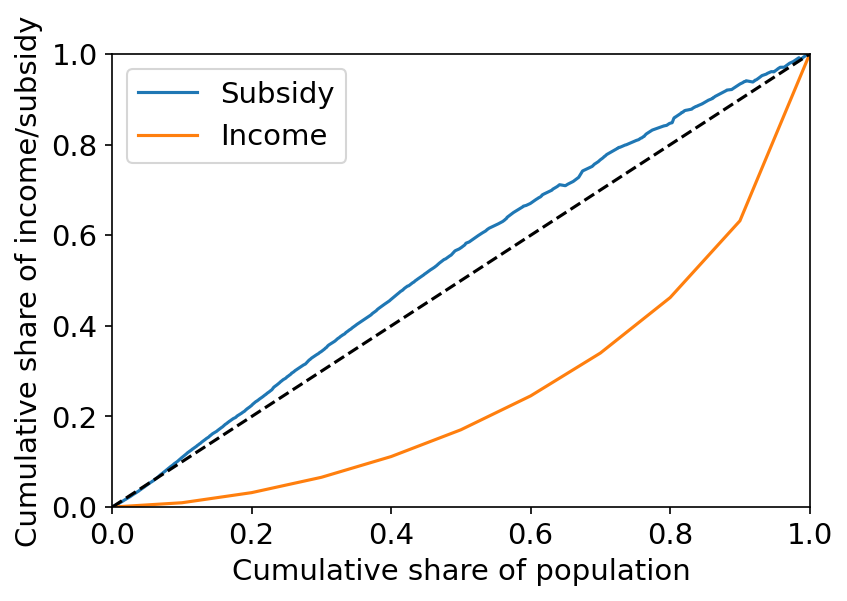

In [ ]:
# Curva de Lorenz actual.

k = 1

# Ingreso acumulado
income = gini.query("Country=='Mexico' & Year==2010"
    ).values[0, 1:-2]
income[0] = 0
income = income.cumsum()
income/= income[-1]

# Ordenamos por ingreso per cápita.
df[k].sort_values("PCI", inplace = True)

# Población acumulada - eje x de Lorenz.
df[k]["Cum_Pop"] = (
    ( df[k]["Poblacion"] ).cumsum()
    / ( df[k]["Poblacion"] ).sum()
    )

# Ingreso acumulado - eje y de Lorenz.
df[k]["Cum_PIB"] = ( df[k]["PIB"].cumsum()
    / df[k]["PIB"].sum() )
# Lorenz para subsidio.
df[k]["Cum_Subs"] = ( df[k]["Subsidio"].cumsum()
    / df[k]["Subsidio"].sum() )

# Graficamos.
plt.rcParams.update( {"font.size": 14, "figure.dpi": 150} )
fig, ax = plt.subplots()
# Información de CFE.
#df[k].plot("Cum_Pop", "Cum_PIB", 
    # color = "k", linestyle = "dotted",
#    ax = ax)
df[k].plot("Cum_Pop", "Cum_Subs",
    #color = "k", linestyle = "solid", 
    ax = ax)
ax.plot(np.arange(0, 1.1, 0.1), income
    #color = "k", linestyle = "solid"
    )
ax.plot([0, 1], [0, 1], color = "k",
    linestyle = "dashed")

ax.set_xlabel("Cumulative share of population")
ax.set_ylabel("Cumulative share of income/subsidy")
ax.legend(["Subsidy", "Income"])
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Coeficiente de Gini para ingreso.
B = np.trapz(income, np.arange(0, 1.1, 0.1))
G = 2 * (0.5 - B)
print(f"Mexico's income Gini coefficient in 2010: {G:.2f}")

# Coeficiente de Gini para ingreso, CFE.
#B = np.trapz(df[k]["Cum_PIB"], df[k]["Cum_Pop"])
#G = 2 * (0.5 - B)
#print(f"Mexico's income Gini coefficient: {G:.2f}")

# Coeficiente de Gini para subsidio.
B = np.trapz(df[k]["Cum_Subs"], df[k]["Cum_Pop"])
G = 2 * (0.5 - B)
print(f"Mexico's electric subsidy Gini coefficient: {G:.2f}")

plt.savefig( path_r + "Lorenz_curve_2.png",
    bbox_inches = "tight" )

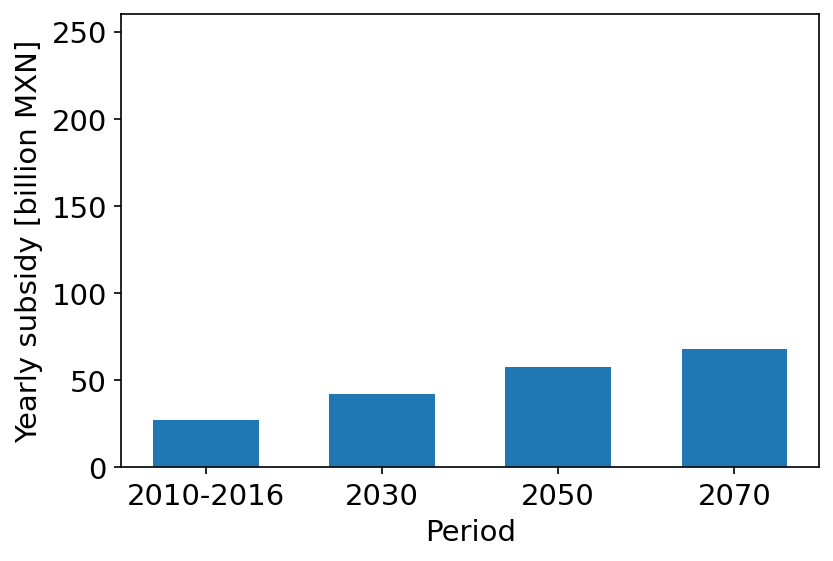

In [ ]:
# Monto total del subsidio.

# Sumamos el subsidio por año.
subs = [ df[x]["Subsidio"].sum() / 1e9 for x in range(1, len(df)) ]

# Convertimos a DataFrame.
df_subs = pd.DataFrame( subs, columns = ["Proposal #2"],
    index = ["2010-2016", "2030", "2050", "2070"] )
# Guardamos el DataFrame.
df_subs.to_csv(path + "CFE/subsidio_2.csv")

# Graficamos.
plt.rcParams.update( {"font.size": 14, "figure.dpi": 150} )
fig, ax = plt.subplots()

x = np.arange(len(subs)) * 0.5
bar_width = 0.3

ax.bar(x, subs, bar_width)
ax.set_xlabel("Period")
ax.set_ylabel("Yearly subsidy [billion MXN]")
ax.set_xticks(x)
ax.set_xticklabels( esc )
ax.set_ylim(0, 260)

plt.savefig( path_r + "Subsidy_evolution_2.png",
    bbox_inches = "tight" )

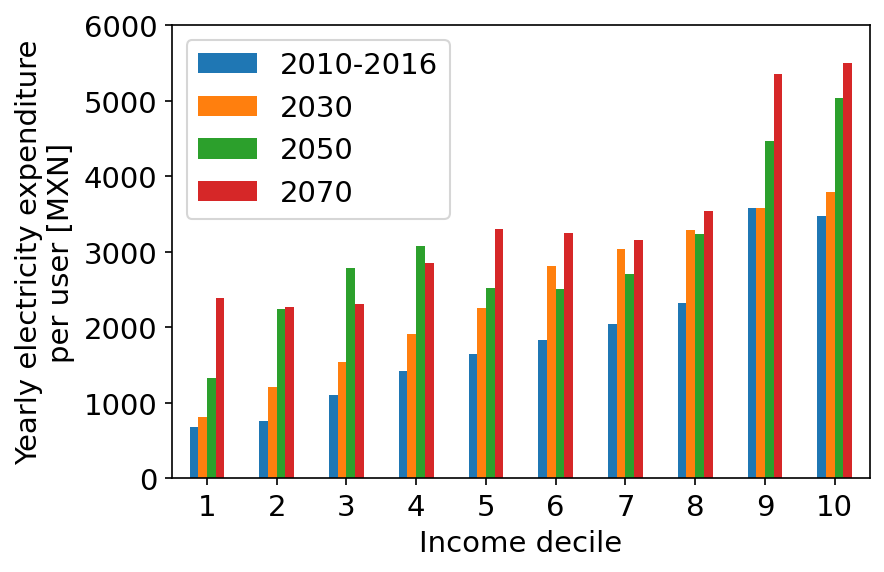

In [ ]:
# Pago promedio por decil.

# Creamos la columna decil.
decil = []
for i in range(1, 11):
    decil += [i] * 247
decil = decil[:-1]

# Creamos el DataFrame para los deciles.
df_2 = pd.DataFrame(np.zeros((10, 4)), columns = esc)
df_2.index += 1

for k in range(1, len(df)):

    # Ordenamos por ingreso per cápita.
    df[k].sort_values("PCI", inplace = True)

    # Agrupamos por decil y promediamos el pago.
    df[k]["Decil"] = decil
    df_2.iloc[:, k - 1] = df[k].groupby(
        "Decil").mean()["Pago_real"]

# Guardamos el DataFrame.
df_2.to_csv(path + "CFE/pago_decil_2.csv")

# Graficamos.
plt.rcParams.update( {"font.size": 14, "figure.dpi": 150} )
fig, ax = plt.subplots()

df_2.plot.bar(ax = ax)

ax.set_xlabel("Income decile")
ax.set_ylabel("Yearly electricity expenditure\nper user [MXN]")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
ax.set_ylim(0, 6000)

plt.savefig( path_r + "Expenditure_deciles_2.png",
    bbox_inches = "tight" )

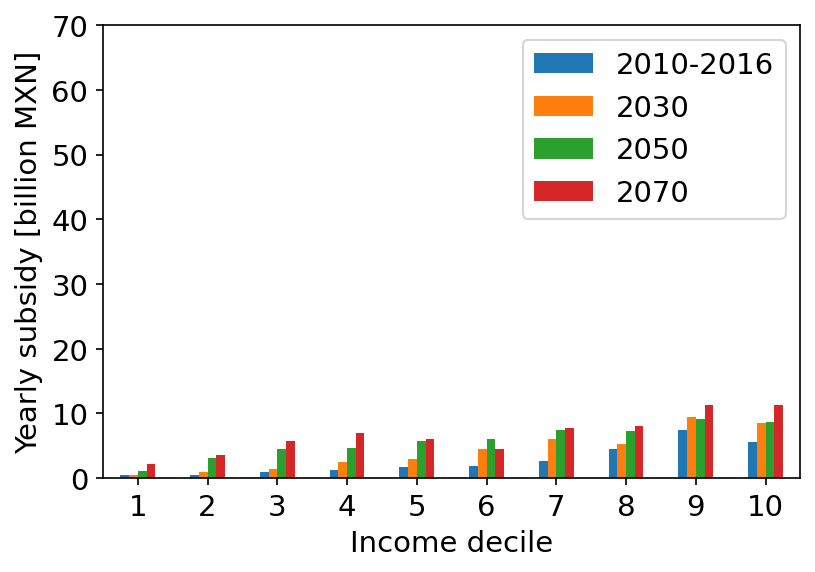

In [ ]:
# Distribución del subsidio.

# Creamos la columna decil.
decil = []
for i in range(1, 11):
    decil += [i] * 247
decil = decil[:-1]

# Creamos el DataFrame para los deciles.
df_2 = pd.DataFrame(np.zeros((10, 4)), columns = esc)
df_2.index += 1

for k in range(1, len(df)):

    # Ordenamos por ingreso per cápita.
    df[k].sort_values("PCI", inplace = True)

    # Agrupamos por decil y sumamos el subsidio.
    df[k]["Decil"] = decil
    df_2.iloc[:, k - 1] = df[k].groupby(
        "Decil").sum()["Subsidio"] / 1e9

# Graficamos.
plt.rcParams.update( {"font.size": 14, "figure.dpi": 150} )
fig, ax = plt.subplots()

df_2.plot.bar(ax = ax)

ax.set_xlabel("Income decile")
ax.set_ylabel("Yearly subsidy [billion MXN]")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
ax.set_ylim(0, 70)

plt.savefig( path_r + "Subsidy_deciles_2.png",
    bbox_inches = "tight" )

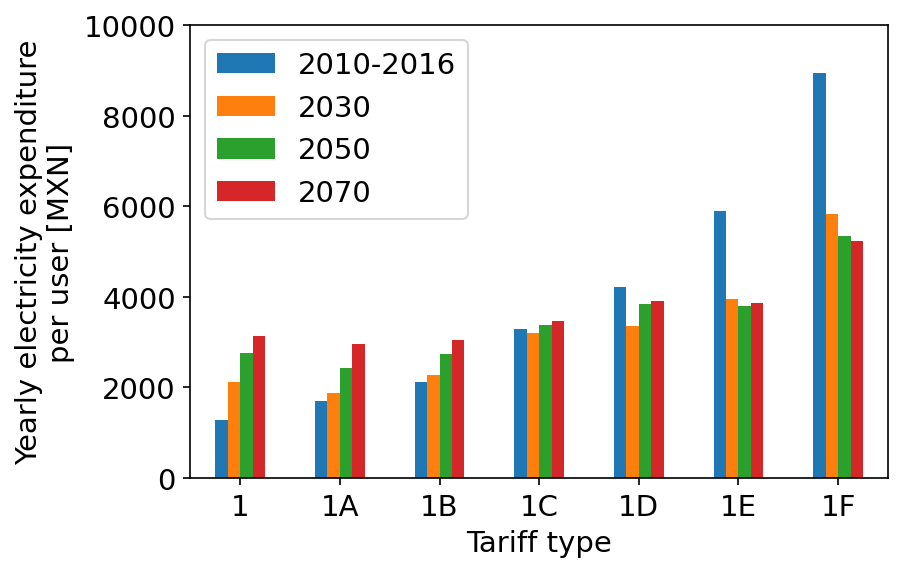

In [ ]:
c = []
for k in range(1, len(df)):
    cons = df[k].groupby("Tarifa").mean()
    cons[esc[k - 1]] = cons["Pago_real"]
    c.append(cons[esc[k - 1]])

count = pd.DataFrame(c).transpose()

# Guardamos el DataFrame.
count.to_csv(path + "CFE/pago_tarifa_2.csv")

# Graficamos.
plt.rcParams.update( {"font.size": 14, "figure.dpi": 150} )
fig, ax = plt.subplots()
count.plot(kind = "bar", # color = "k"
    ax = ax)

ax.set_xlabel("Tariff type")
ax.set_ylabel("Yearly electricity expenditure\nper user [MXN]")
ax.tick_params(axis = "x", rotation = 0)
ax.set_ylim(0, 10000)
# Notación matemática y exponente de notación científica fijo.
#ax.yaxis.set_major_formatter(OOMFormatter(10, "%1.1f"))

plt.savefig( path_r + "Expenditure_tariff_2.png",
    bbox_inches = "tight" )

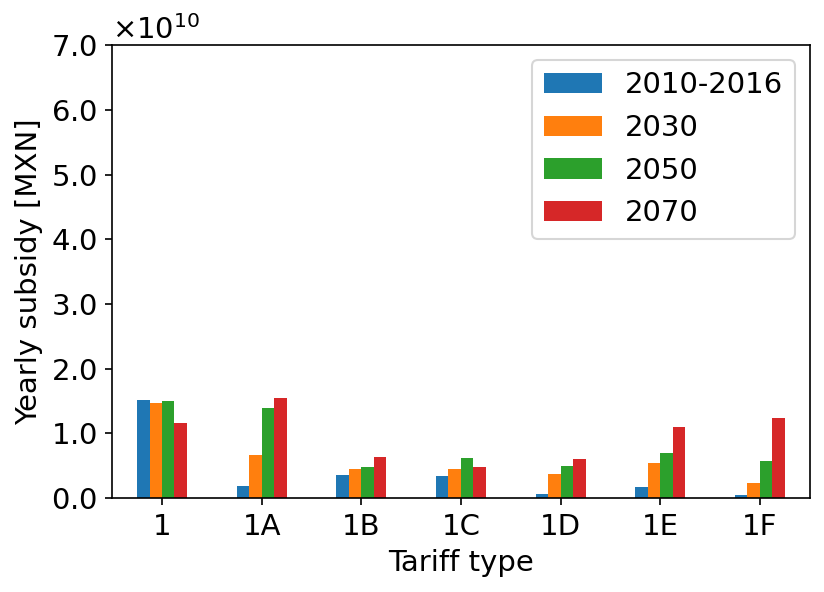

In [ ]:
c = []
for k in range(1, len(df)):
    cons = df[k].groupby("Tarifa").sum()
    cons[esc[k - 1]] = cons["Subsidio"]
    c.append(cons[esc[k - 1]])

count = pd.DataFrame(c).transpose()

# Graficamos.
plt.rcParams.update( {"font.size": 14, "figure.dpi": 150} )
fig, ax = plt.subplots()
count.plot(kind = "bar", # color = "k"
    ax = ax)

ax.set_xlabel("Tariff type")
ax.set_ylabel("Yearly subsidy [MXN]")
ax.tick_params(axis = "x", rotation = 0)
ax.set_ylim(0, 7e10)
# Notación matemática y exponente de notación científica fijo.
ax.yaxis.set_major_formatter(OOMFormatter(10, "%1.1f"))

plt.savefig( path_r + "Subsidy_tariff_2.png",
    bbox_inches = "tight" )

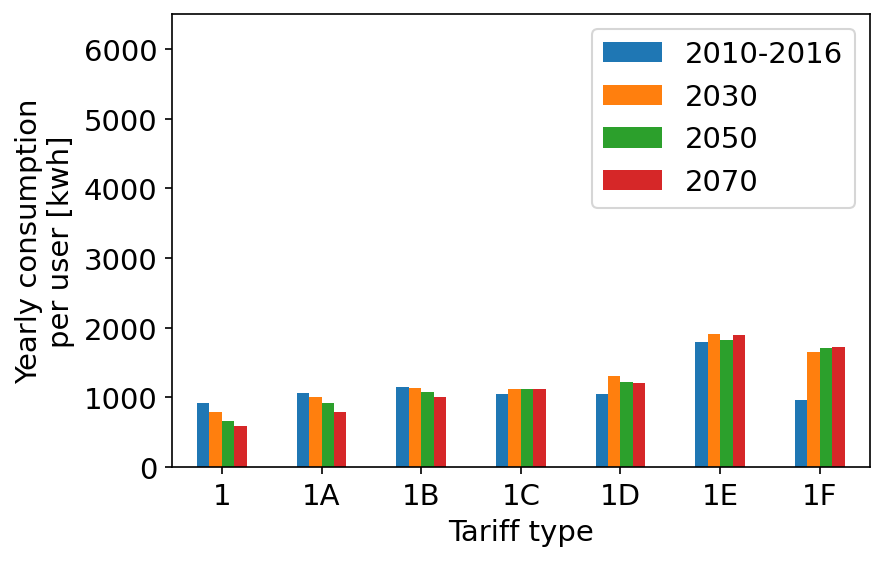

In [ ]:
c = []
for k in range(1, len(df)):
    cons = df[k].groupby("Tarifa").mean()
    cons[esc[k - 1]] = cons["Subsidio_Usuario"]
    c.append(cons[esc[k - 1]])

count = pd.DataFrame(c).transpose()

# Graficamos.
plt.rcParams.update( {"font.size": 14, "figure.dpi": 150} )
fig, ax = plt.subplots()
count.plot(kind = "bar", # color = "k"
    ax = ax)

ax.set_xlabel("Tariff type")
ax.set_ylabel("Yearly subsidy per user [MXN]")
ax.tick_params(axis = "x", rotation = 0)
ax.set_ylabel("Yearly consumption\nper user [kwh]")
ax.set_ylim(0, 6500)
# Notación matemática y exponente de notación científica fijo.
#ax.yaxis.set_major_formatter(OOMFormatter(6, "%1.1f"))

plt.savefig( path_r + "Subsidy_user_2.png",
    bbox_inches = "tight" )

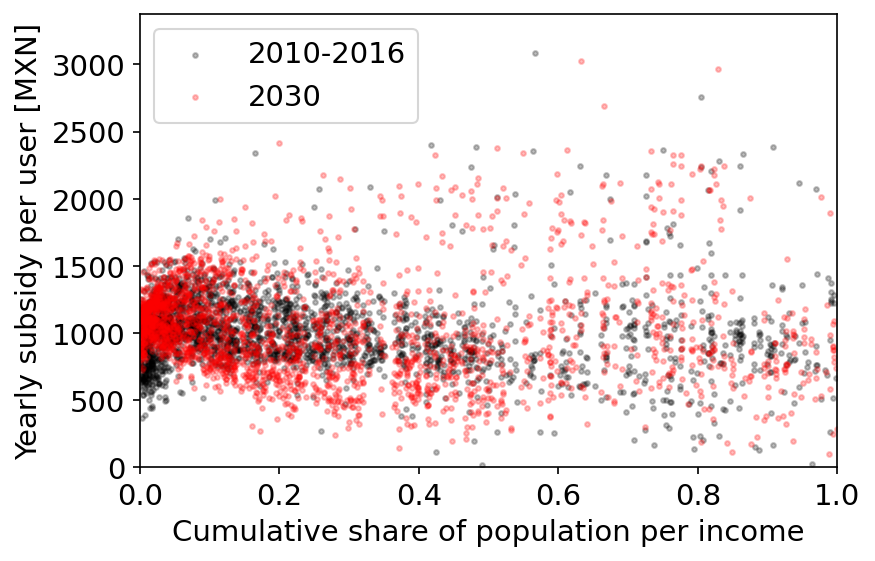

In [ ]:
# Distribución del subsidio per cápita.

# Población acumulada.
df[2]["Cum_Pop"] = (
    ( df[2]["Poblacion"] ).cumsum()
    / ( df[2]["Poblacion"] ).sum()
    )

# Graficamos la distribución para todas las tarifas.
plt.rcParams.update( {"font.size": 14, "figure.dpi": 150} )
fig, ax = plt.subplots()

# Actual.
ax.scatter(df[1]["Cum_Pop"], df[1]["Subsidio_Usuario"],
    color = "k", s = 5, alpha = 0.25)
# 2030.
ax.scatter(df[2]["Cum_Pop"], df[2]["Subsidio_Usuario"],
    color = "r", s = 5, alpha = 0.25)

ax.set_xlabel("Cumulative share of population per income")
ax.set_ylabel("Yearly subsidy per user [MXN]")
ax.legend(esc[0:2])
ax.set_xlim(0, 1)
ax.set_ylim(0)

plt.savefig( path_r + "Per_capita_subsidy_2.png",
    bbox_inches = "tight" )

2010-2016
Mexico's electric subsidy Gini coefficient: -0.09

2030
Mexico's electric subsidy Gini coefficient: -0.11

2050
Mexico's electric subsidy Gini coefficient: -0.24

2070
Mexico's electric subsidy Gini coefficient: -0.21



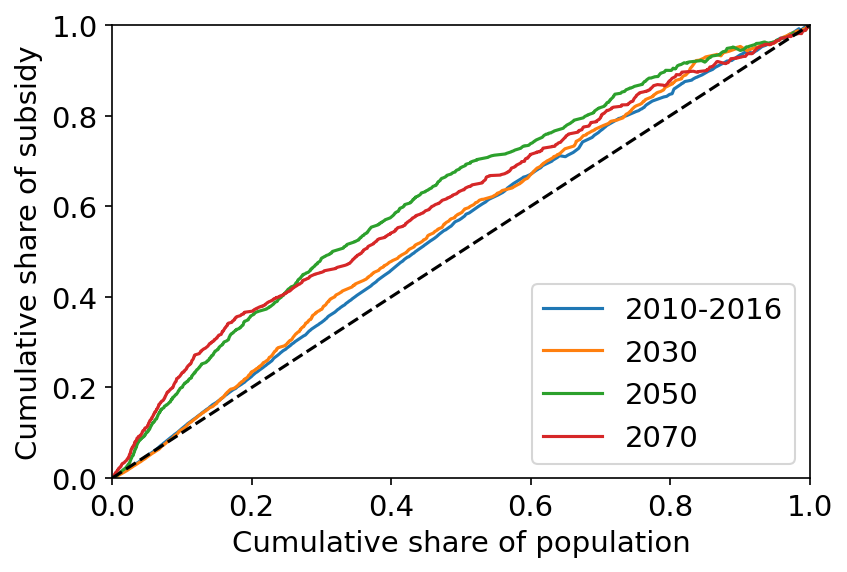

In [ ]:
# Curva de Lorenz por periodo.

plt.rcParams.update( {"font.size": 14, "figure.dpi": 150} )
fig, ax = plt.subplots()

for k in range(1, len(df)):

    # Ordenamos por ingreso per cápita.
    df[k].sort_values("PCI", inplace = True)

    # Población acumulada - eje x de Lorenz.
    df[k]["Cum_Pop"] = (
        ( df[k]["Poblacion"] ).cumsum()
        / ( df[k]["Poblacion"] ).sum()
        )

    # Lorenz para subsidio.
    df[k]["Cum_Subs"] = ( df[k]["Subsidio"].cumsum()
        / df[k]["Subsidio"].sum() )

    # Graficamos.
    df[k].plot("Cum_Pop", "Cum_Subs", #color = "k",
        linestyle = "solid", ax = ax)

    # Coeficiente de Gini para subsidio.
    B = np.trapz(df[k]["Cum_Subs"], df[k]["Cum_Pop"])
    G = 2 * (0.5 - B)
    print(esc[k - 1])
    print(f"Mexico's electric subsidy Gini coefficient: {G:.2f}")
    print()

ax.plot([0, 1], [0, 1], color = "k",
    linestyle = "dashed")

ax.set_xlabel("Cumulative share of population")
ax.set_ylabel("Cumulative share of subsidy")
ax.legend(esc)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.savefig( path_r + "gini_subsidy_2.png",
    bbox_inches = "tight" )

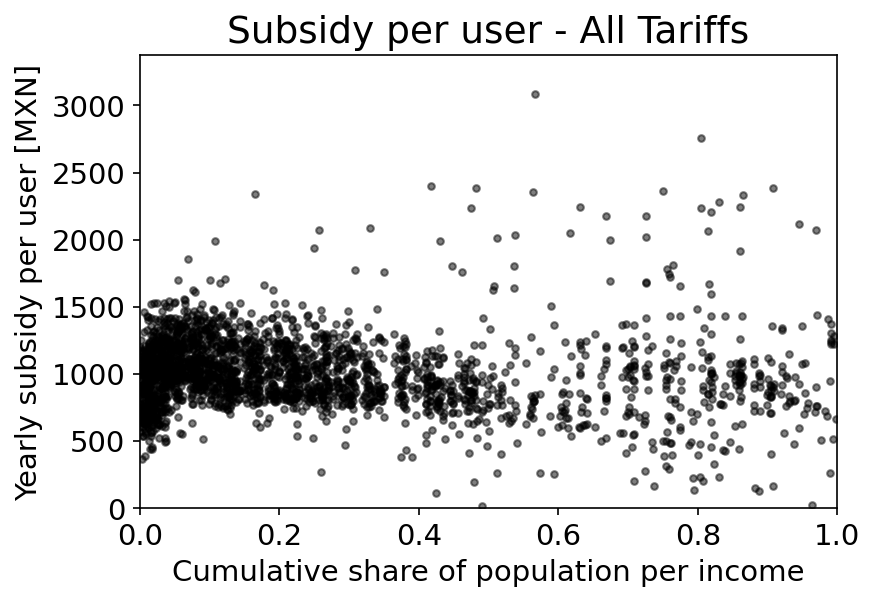

In [ ]:
# Distribución del subsidio per cápita.

k = 1

# Ordenamos por ingreso per cápita.
df[k].sort_values("PCI", inplace = True)

# Población acumulada - eje x.
df[k]["Cum_Pop"] = (
    ( df[k]["Poblacion"] ).cumsum()
    / ( df[k]["Poblacion"] ).sum()
    )

# Graficamos la distribución para todas las tarifas.
plt.rcParams.update( {"font.size": 14, "figure.dpi": 150} )
fig, ax = plt.subplots()

ax.scatter(df[k]["Cum_Pop"], df[k]["Subsidio_Usuario"],
    color = "k", s = 10, alpha = 0.5)

ax.set_title("Subsidy per user - All Tariffs",
    fontsize = 18)
ax.set_xlabel("Cumulative share of population per income")
ax.set_ylabel("Yearly subsidy per user [MXN]")
ax.set_xlim(0, 1)
ax.set_ylim(0)


# Repetimos para cada la tarifa.
T = ["1", "1A", "1B", "1C",
    "1D", "1E", "1F"]

for t in T:
    # Seleccionamos los municipios
    # con la tarifa en cuestión.
    df_i = df[k][df[k]["Tarifa"] == t].copy()

    # Cantidad de municipios.
    n = df_i.shape[0]

    # Ordenamos por ingreso per cápita.
    df_i["Cum_Pop"] = (
        ( df_i["Poblacion"] ).cumsum()
        / ( df_i["Poblacion"] ).sum()
        )

    # Graficamos.
    plt.rcParams.update({"font.size": 14})
    #fig, ax = plt.subplots()
    #ax.scatter(df_i["Cum_Pop"],
    #    df_i["Subsidio_Usuario"], color = "k",
    #    s = 10, alpha = 0.5 + 7 / n )

    #ax.set_title("Subsidy per user - Tariff " + t,
    #    fontsize = 18)
    #ax.set_xlabel("Cumulative share of population per income")
    #ax.set_ylabel("Yearly subsidy per user [MXN]")
    #ax.set_xlim(0, 1)
    #ax.set_ylim(0)

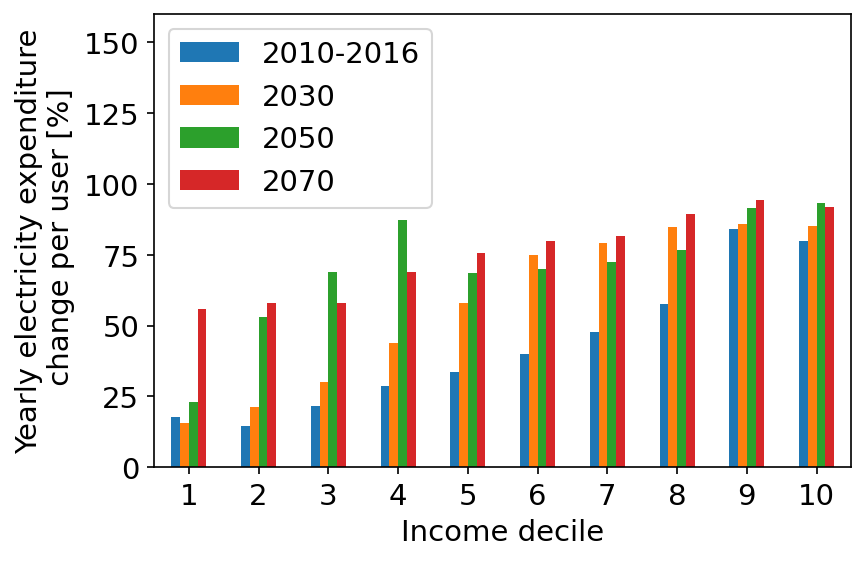

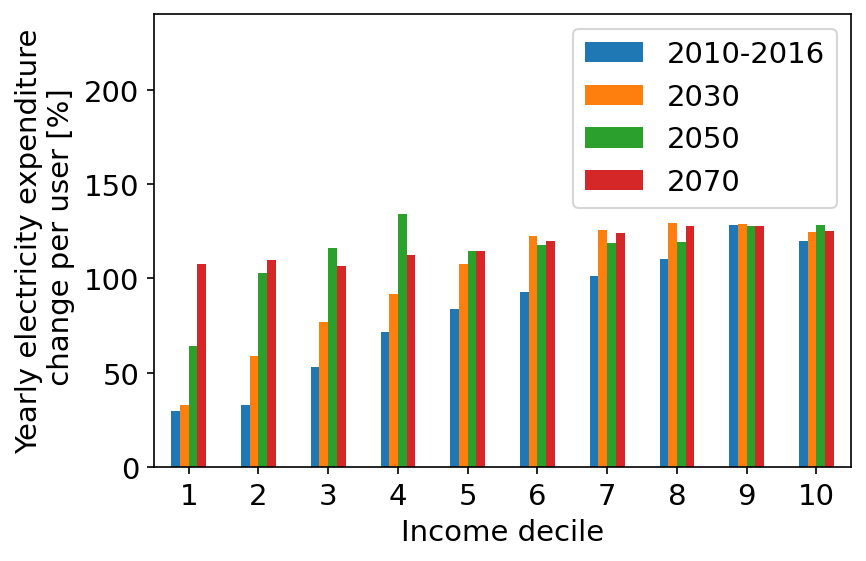

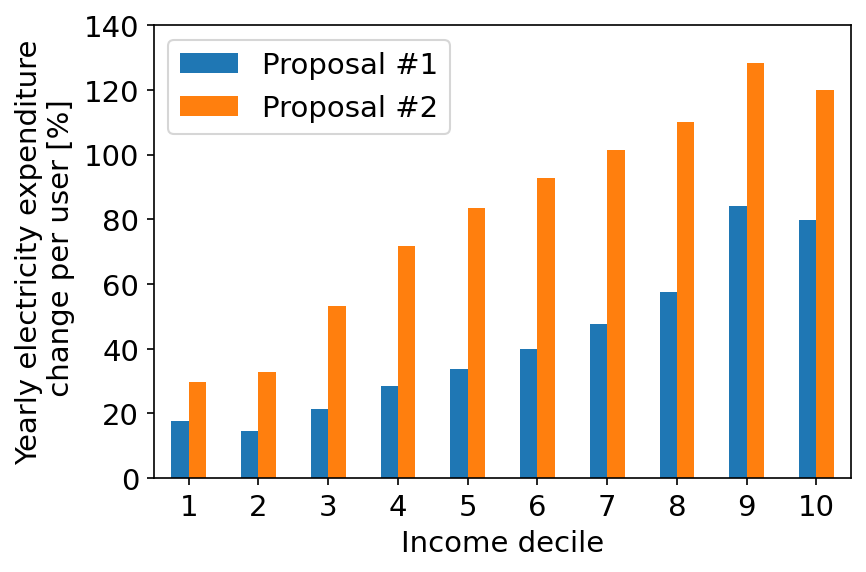

In [ ]:
pago_decil = []

for i in range(0, 3):
    pago_decil.append( pd.read_csv(path
        + f"CFE/pago_decil_{i}.csv", index_col = 0) )

pago_decil[1] = ( pago_decil[1] / pago_decil[0] - 1 ) * 100
pago_decil[2] = ( pago_decil[2] / pago_decil[0] - 1 ) * 100

pago_decil.append( pd.concat( [ pago_decil[1]["2010-2016"],
    pago_decil[2]["2010-2016"] ], axis = 1 ) )
pago_decil[3].columns = ["Proposal #1", "Proposal #2"]

for i in range(1, 4):
    # Graficamos.
    plt.rcParams.update( {"font.size": 14, "figure.dpi": 150} )
    fig, ax = plt.subplots()

    pago_decil[i].plot.bar(ax = ax)

    ax.set_xlabel("Income decile")
    ax.set_ylabel("Yearly electricity expenditure\n change per user [%]")
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
    if i == 1: ax.set_ylim(0, 160)
    elif i == 2: ax.set_ylim(0, 240)
    elif i == 3: ax.set_ylim(0, 140)

    plt.savefig( path_r + f"expenditure_increase_{i}.png",
        bbox_inches = "tight" )


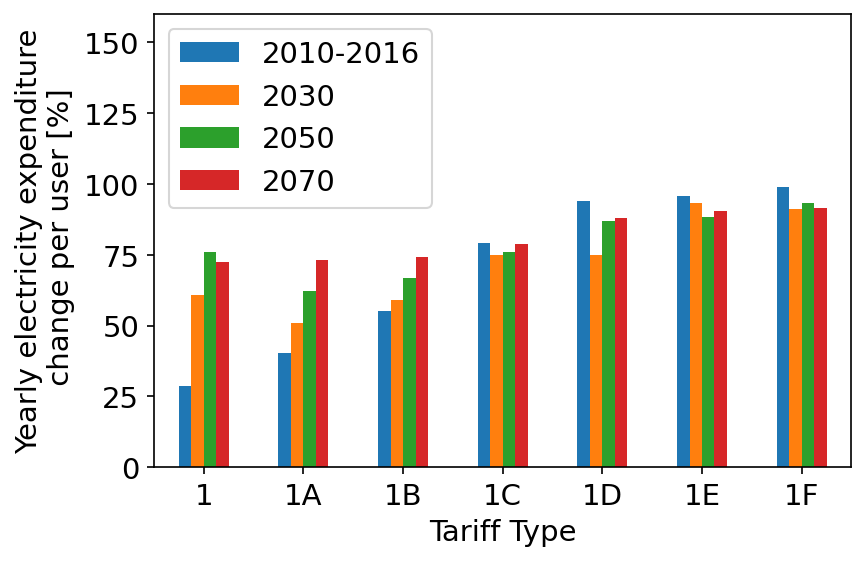

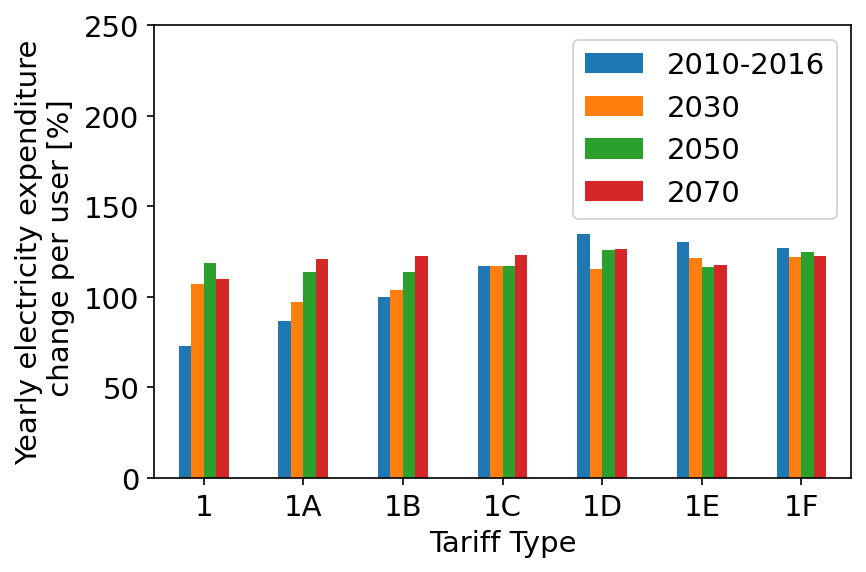

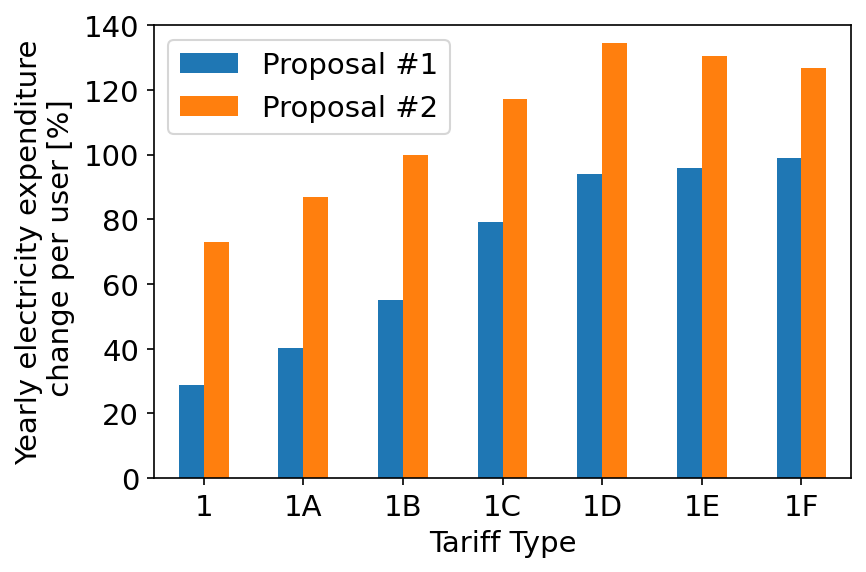

In [ ]:
pago_decil = []

for i in range(0, 3):
    pago_decil.append( pd.read_csv(path
        + f"CFE/pago_tarifa_{i}.csv", index_col = 0) )

pago_decil[1] = ( pago_decil[1] / pago_decil[0] - 1 ) * 100
pago_decil[2] = ( pago_decil[2] / pago_decil[0] - 1 ) * 100

pago_decil.append( pd.concat( [ pago_decil[1]["2010-2016"],
    pago_decil[2]["2010-2016"] ], axis = 1 ) )
pago_decil[3].columns = ["Proposal #1", "Proposal #2"]

for i in range(1, 4):
    # Graficamos.
    plt.rcParams.update( {"font.size": 14, "figure.dpi": 150} )
    fig, ax = plt.subplots()

    pago_decil[i].plot.bar(ax = ax)

    ax.set_xlabel("Tariff Type")
    ax.set_ylabel("Yearly electricity expenditure\n change per user [%]")
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
    if i == 1: ax.set_ylim(0, 160)
    elif i == 2: ax.set_ylim(0, 250)
    elif i == 3: ax.set_ylim(0, 140)

    plt.savefig( path_r + f"expenditure_increase_{i}.png",
        bbox_inches = "tight" )


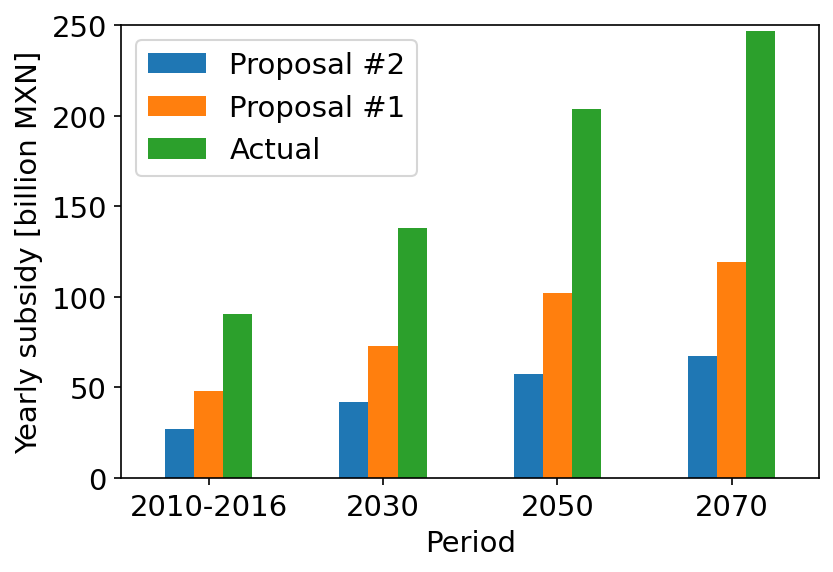

In [ ]:
pago_decil = []

subs = pd.read_csv( path + f"CFE/subsidio_2.csv", index_col = 0 )

for i in [1, 0]:
    subs = pd.concat( [ subs, pd.read_csv(
        path + f"CFE/subsidio_{i}.csv", index_col = 0 ) ], axis = 1 )

# Graficamos.
plt.rcParams.update( {"font.size": 14, "figure.dpi": 150} )
fig, ax = plt.subplots()

subs.plot.bar(ax = ax)

ax.set_xlabel("Period")
ax.set_ylabel("Yearly subsidy [billion MXN]")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
ax.set_ylim(0, 250)

plt.savefig( path_r + f"Subsidy_proposals.png",
    bbox_inches = "tight" )
